In [1]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
from PIL import Image
import os

In [2]:
device = torch.device("cuda")

In [3]:
def get_sample_image(root_dir=r"C:\Users\uchit\OneDrive\Desktop\Datasets\MPM_Part04_L0001"):
    """
    Loads the first image from the specified directory.

    Args:
        root_dir (str, optional): Path to the directory containing images. Defaults to a specific path on the user's desktop.

    Returns:
        PIL.Image.Image: The first image in the directory.
    """
    # Create a list of filenames in the directory that end with '.bmp' (bitmap image file)
    image_names = [f for f in os.listdir(root_dir) if f.endswith(".bmp")]
    
    # Check if no images were found in the directory; if so, raise an error
    if not image_names:
        raise ValueError("No images found in the specified directory.")
    
    # Construct the full path to the first image in the list
    image_path = os.path.join(root_dir, image_names[0])
    
    # Open and return the image using PIL's Image module
    return Image.open(image_path)


In [4]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [5]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [6]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if 
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3
            
        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)
        
        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
        
        

In [7]:
IMAGE_SHAPE = (32, 32)
torch.cuda.empty_cache()

In [8]:
def scale_pixels(t):
    """
    Scales the pixel values from [0, 1] to [-1, 1].

    Args:
        t (torch.Tensor): Tensor containing pixel values in range [0, 1].

    Returns:
        torch.Tensor: Tensor with pixel values scaled to range [-1, 1].
    """
    return (t * 2) - 1

# Transformation pipeline for preprocessing images
transform = transforms.Compose([
    transforms.Resize((IMAGE_SHAPE)),        # Resizes the image to the specified dimensions (64, 64)
    transforms.ToTensor(),                   # Converts images to PyTorch tensors and scales pixel values to [0, 1]
    transforms.Lambda(scale_pixels)          # Scales pixel values from [0, 1] to [-1, 1]
])

# Transformation pipeline for postprocessing images
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),                # Rescales tensors from [-1, 1] back to [0, 1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),         # Rearranges the tensor dimensions from CHW (Channels, Height, Width)
                                                             # format to HWC (Height, Width, Channels)
    transforms.Lambda(lambda t: t * 255.),                   # Scales pixel values from [0, 1] to [0, 255]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),  # Moves the tensor to CPU, converts it to a NumPy array,
                                                                    # and changes the data type to unsigned 8-bit integer
    transforms.ToPILImage()                                  # Converts the NumPy array to a PIL image for display or saving
])


In [9]:
diffusion_model = DiffusionModel()

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [11]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [12]:
class UNet(nn.Module):
    def __init__(self, img_channels=3, time_embedding_dims=128, labels=False, sequence_channels=(64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [13]:
BATCH_SIZE = 256
NO_EPOCHS = 150
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = False

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [14]:
class MPMDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.image_names = [f for f in os.listdir(root_dir) if f.endswith(".bmp")]

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    image_name = self.image_names[idx]
    image_path = os.path.join(self.root_dir, image_name)
    image = Image.open(image_path).convert('RGB')  # Convert to grayscale
    # Apply your preprocessing steps here (resize, normalization, etc.)
    transformed_image = transform(image)  # Use your defined transform
    return transformed_image


In [15]:
dataset = MPMDataset(root_dir=r"C:\Users\uchit\OneDrive\Desktop\Datasets\MPM_Part04_L0001")
trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

dataset = MPMDataset(root_dir=r"C:\Users\uchit\OneDrive\Desktop\Datasets\MPM_Part04_L0150")
testloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

In [16]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        loss
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for batch in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        predicted_noise = unet(batch_noisy, t)

        loss = torch.nn.functional.mse_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.6885244482093387 | Val Loss 0.387894743680954
---
Epoch: 10 | Train Loss 0.06703068481551276 | Val Loss 0.060767154395580295
---
Epoch: 20 | Train Loss 0.02373525852130519 | Val Loss 0.02596203573048115
---
Epoch: 30 | Train Loss 0.018028422569235165 | Val Loss 0.023045000806450843
---
Epoch: 40 | Train Loss 0.01245808301286565 | Val Loss 0.021851138770580293
---
Epoch: 50 | Train Loss 0.01163763263159328 | Val Loss 0.019544196873903276
---
Epoch: 60 | Train Loss 0.011253170358637968 | Val Loss 0.01925969012081623
---
Epoch: 70 | Train Loss 0.009866461571719911 | Val Loss 0.017665665969252585
---
Epoch: 80 | Train Loss 0.008854019714312421 | Val Loss 0.016323170438408852
---
Epoch: 90 | Train Loss 0.009339006721145578 | Val Loss 0.01652805618941784
---
Epoch: 100 | Train Loss 0.0081253114880787 | Val Loss 0.01638411693274975
---
Epoch: 110 | Train Loss 0.009799351812236838 | Val Loss 0.015711674466729164
---
Epoch: 120 | Train Loss 0.007378756327347623 | Val

In [17]:
unet = UNet(labels=False)
unet.load_state_dict(torch.load(("epoch: 140")))

<All keys matched successfully>

In [18]:

NUM_DISPLAY_IMAGES = 5

torch.Size([5, 3, 32, 32])


<Figure size 1500x500 with 0 Axes>

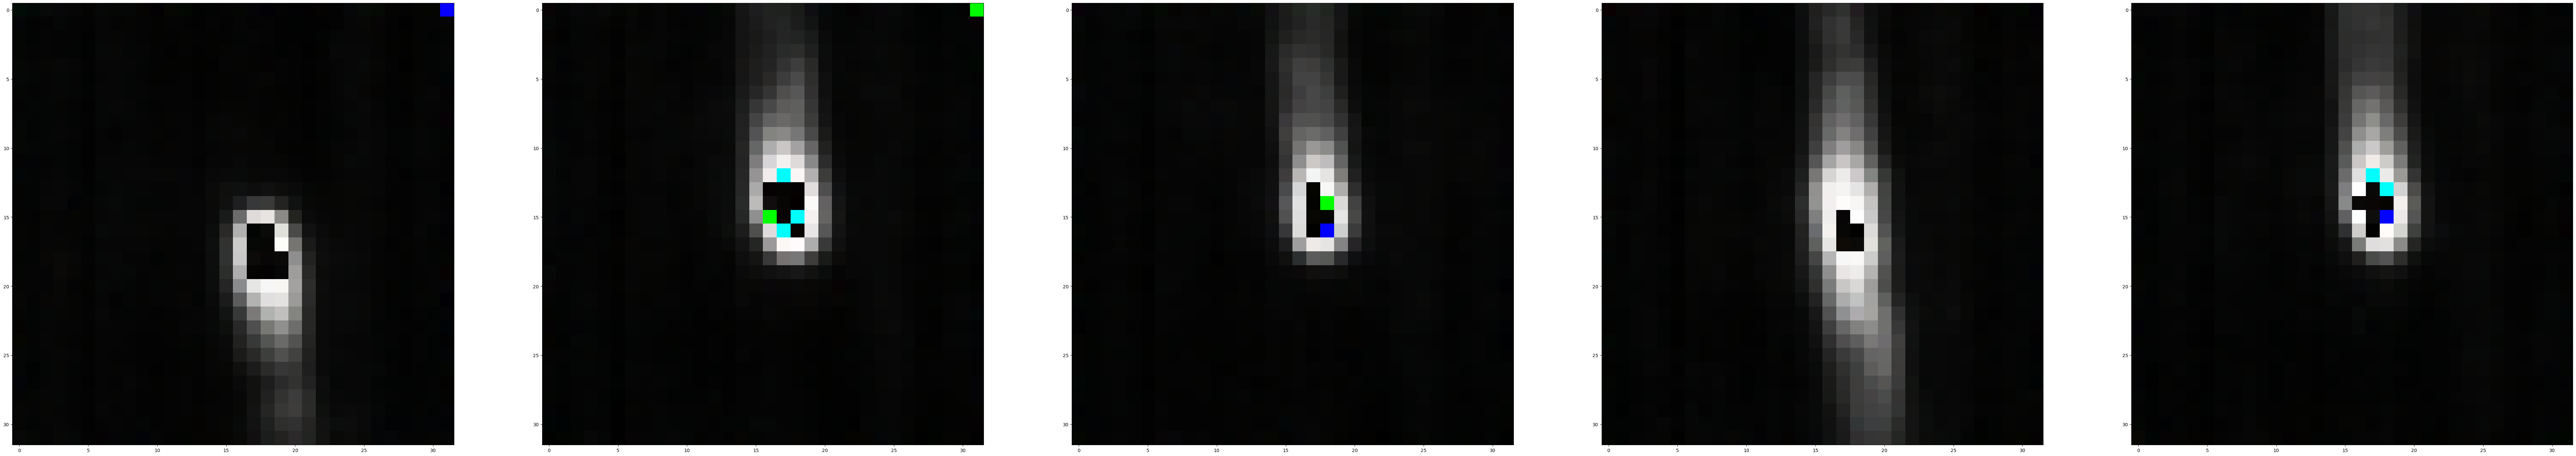

In [19]:
torch.manual_seed(16)

plt.figure(figsize=(15,5))  # Adjust figure size for a single row
f, ax = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize = (100,100))

# Generate random noise as input
imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
print(imgs.shape)

for i in reversed(range(diffusion_model.timesteps)):
  t = torch.full((1,), i, dtype=torch.long, device=device)
  imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device))

for idx, img in enumerate(imgs):
  ax[idx].imshow(reverse_transform(img))
  
plt.show()